#Task 1 - Gender Classification

#data preperation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf /content/drive/MyDrive/voiseed/dev-clean.tar.gz 

In [4]:
!ls /content/LibriSpeech

BOOKS.TXT  CHAPTERS.TXT  dev-clean  LICENSE.TXT  README.TXT  SPEAKERS.TXT


In [5]:
import pandas as pd
df=pd.read_fwf('/content/LibriSpeech/SPEAKERS.TXT',delimiter='|',skiprows=12, names=['id', 'sex', 'subset', 'minutes', 'name'])


In [6]:
df['sex'] = df['sex'].str.strip()
df['subset'] = df['subset'].str.strip()
df['name'] = df['name'].str.strip()

dev-clean has 20 male and 20 Female

In [9]:
df.value_counts(["sex", "subset"])

sex  subset         
M    train-other-500    602
F    train-other-500    564
M    train-clean-360    482
F    train-clean-360    439
M    train-clean-100    126
F    train-clean-100    125
     dev-clean           20
     test-clean          20
M    dev-clean           20
     test-clean          20
F    test-other          17
M    dev-other           17
F    dev-other           16
M    test-other          16
dtype: int64

Take only the dev-clean subset

In [10]:
newdf = df.loc[df['subset'] == "dev-clean"].reset_index(drop=True)

In [99]:
df = newdf

To make the same sample lengths

#Feature Extraction

The output of librosa.feature.mfcc() is a 2D numpy array where each row represents one coefficient and each column represents a time frame. For classification, we typically want to have a fixed number of features (MFCC coefficients) for each example, regardless of the length of the input audio signal. Therefore, we take the mean of the MFCC coefficients across all time frames which returns a 1D numpy array containing the average values of each MFCC coefficient. We take usually only 12-20 mfcc features. Here we take 13 features. This is because 13 coefficients capture most of the information needed for speech recognition tasks, while higher numbers may not provide much additional benefit and may increase the computational complexity of the system.

In [100]:
import librosa
from matplotlib import pyplot as plt
import numpy as np

This function extracts 13 mfcc features from the audio

In [101]:
def extract_features(file):
    audio,sample_rate = librosa.load(file)
    extracted_features = librosa.feature.mfcc(y=audio,
                                              sr=sample_rate,
                                              n_mfcc=13)
    #in order to find out scaled feature we do mean of transpose of value
    extracted_features = np.mean(extracted_features.T,axis=0)
    return extracted_features

In this section we create 2 dfs.

"New" -  with mfcc values and ids and the sex of each audio file

"Final" - with mfcc values in 13 columns and the sex - for analysis

In [ ]:
ind = pd.DataFrame(columns=['id', 'filename', 'mfcc'])
ids = df["id"].values.tolist()
fi = []
import os
import glob
from fnmatch import fnmatch
root = "/content/LibriSpeech/dev-clean/"

for id in ids:
    s = str(id)
    pattern = os.path.join(root, f'{s}/*/*.flac')
    files = glob.glob(pattern)
    for file in files:
        fi.append(file)


ind["filename"] = fi
name = [(s.split("/")[-1]) for s in fi]
slist = [(s.split("-")[0]) for s in name]
ind["id"] = [int(s) for s in slist]

# extract features from all files

for i in range(len(fi)):
  feature = extract_features(ind["filename"][i])
  ind["mfcc"][i] = feature


In [103]:
df1 = ind[['id','mfcc']].copy()
new = pd.merge(df1,df[['id','sex']],on='id', how='left')

We have the df called "new" for training

In [104]:
new.sex = new.sex.map(dict(F=1, M=0))

In [105]:
final = new[['mfcc','sex']].copy()
final['sex'].value_counts()

1    1374
0    1329
Name: sex, dtype: int64

In [107]:
mfcc = final.mfcc.to_list()
sex = final.sex.tolist()

In [108]:
final = pd.DataFrame(final["mfcc"].to_list(), columns=['m1', 'm2', 'm3','m4','m5','m6','m7','m8','m9','m10','m11','m12','m13'])

In [109]:
final["sex"] = sex

We have the df called final which can be used for analysis

In [110]:
final.head(1)

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,sex
0,-351.11319,87.796471,-7.118527,42.184116,-20.00511,8.828368,-15.006772,-15.192313,-11.871531,2.177989,-4.874781,-3.769241,-0.928241,1


# Data Analysis

Now as we have our features we can do data analysis.

In [111]:
X = np.array(new.mfcc.tolist())
y = np.array(new.sex.tolist())

## z-score for outliers

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

Here we remove the outliers based on z-score But after training the models ,we can notice that removing outliers decreases the model accuracy. So whole dataset was used for traning rather than the clean version

In [112]:
final1 = final.copy()
from scipy import stats
z_scores = stats.zscore(final1.iloc[:,1:], axis=0)
abs_z_scores = np.abs(z_scores)
outlier_idx = np.where(abs_z_scores > 3)[0] 

# Print information about outliers
print("Number of outliers detected:", len(outlier_idx))


clean = final1.drop(index=outlier_idx)
clean = new.drop(index=outlier_idx)
clean.reset_index(drop=True, inplace=True)

Number of outliers detected: 171


## histogram

Here we plot the histograms of all numerical features. 

All of them seems to have a **bell shape denoting a normal distribution**

array([[<Axes: title={'center': 'm1'}>, <Axes: title={'center': 'm2'}>,
        <Axes: title={'center': 'm3'}>, <Axes: title={'center': 'm4'}>],
       [<Axes: title={'center': 'm5'}>, <Axes: title={'center': 'm6'}>,
        <Axes: title={'center': 'm7'}>, <Axes: title={'center': 'm8'}>],
       [<Axes: title={'center': 'm9'}>, <Axes: title={'center': 'm10'}>,
        <Axes: title={'center': 'm11'}>, <Axes: title={'center': 'm12'}>],
       [<Axes: title={'center': 'm13'}>, <Axes: title={'center': 'sex'}>,
        <Axes: >, <Axes: >]], dtype=object)

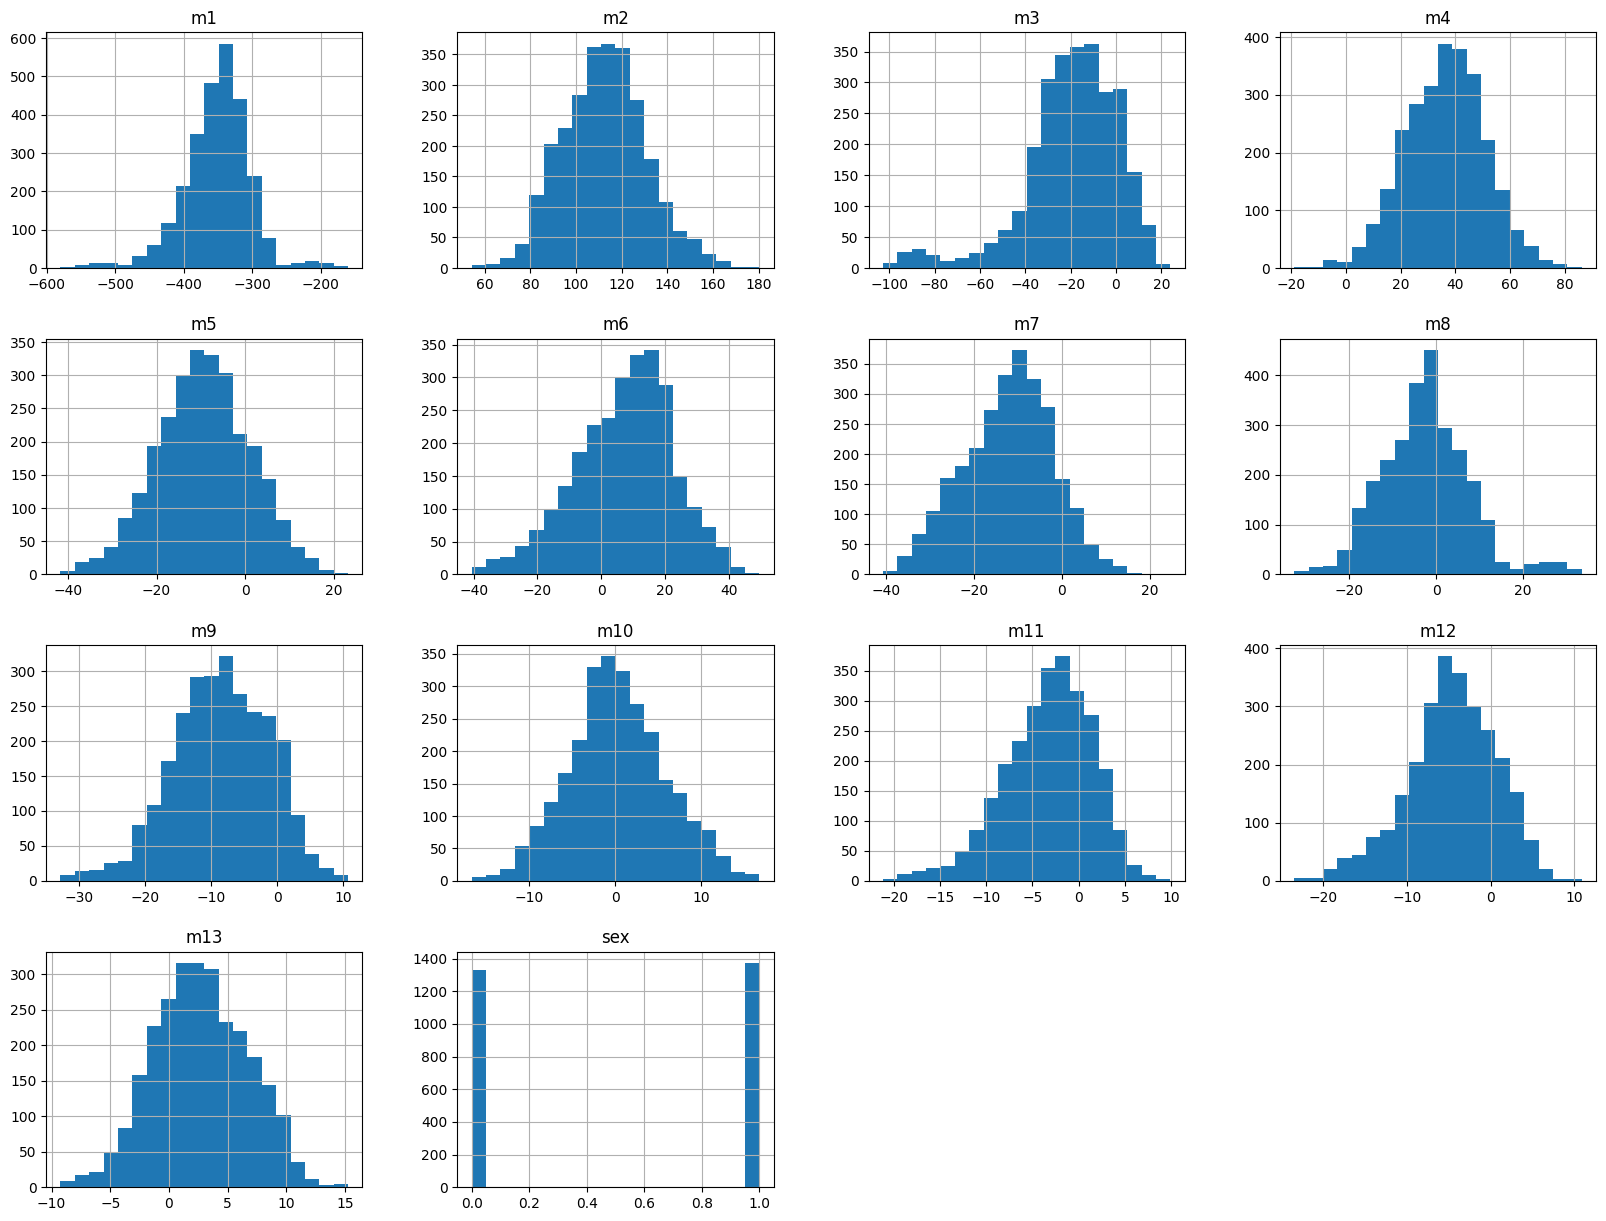

In [113]:
final.hist(bins=20,figsize=(20, 15))

## distribution plot

Now we create distribution plot of our dataset.This allows us to visualize any differences in the distribution of the variable between male and female in the dataset.

As most of the distributions are overlapping, it means that there is a significant amount of shared values between the two genders for most features. 

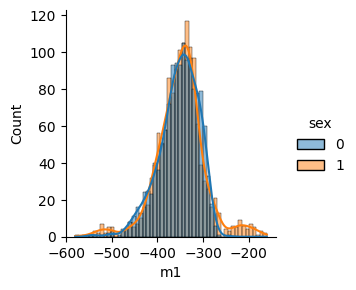

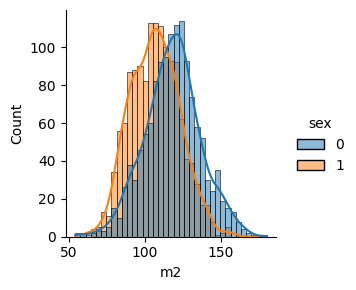

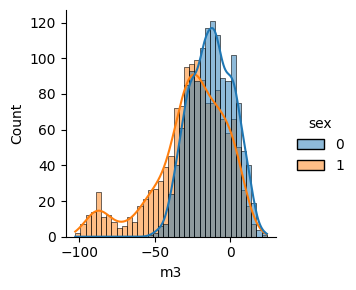

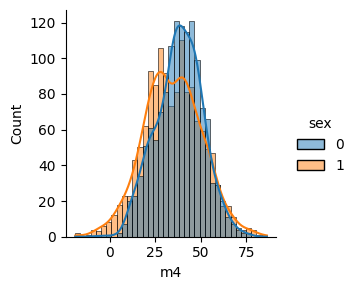

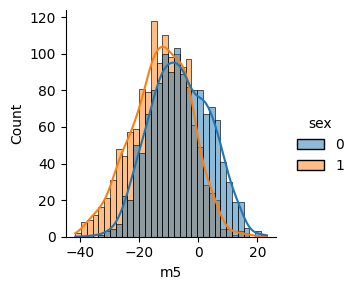

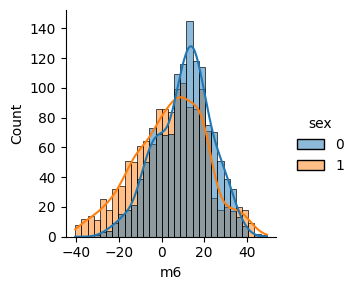

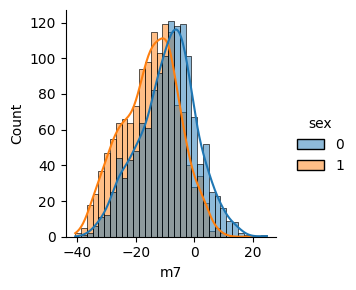

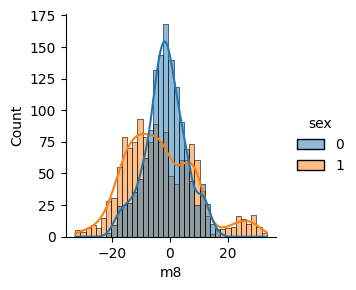

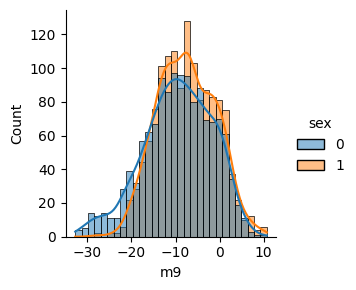

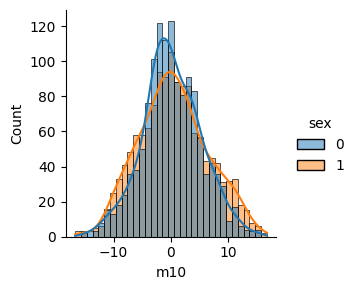

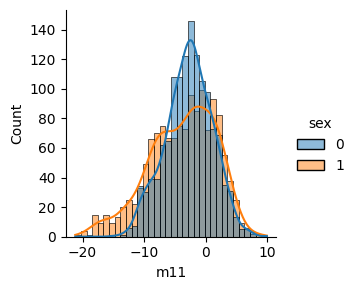

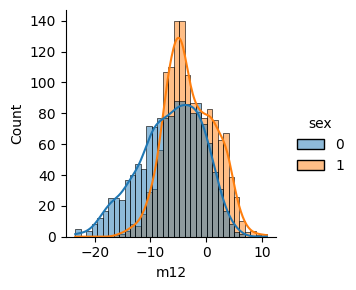

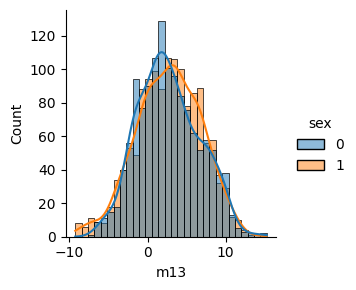

In [114]:

import seaborn as sns
for i in range(13):
  name ="m" + str(i+1)
  sns.displot(final, x=name, hue="sex", kde=True, height=3)
  plt.show()


# Model training

Now let us train the classifiers

Accuracy of models decresed when the ouliers were removed. So I decided to use the whole dataset instead of the clean one 

In [150]:
X = np.array(new.mfcc.tolist())
y = np.array(new.sex.tolist())

Now to split the dataset to train and test. To avoid a speaker's audio being in both train and test, we first make the list of ids of each speaker. then we split the ids list with 20% ids in test and rest in train. Then we make the train and test datasets using the splitted ids list. This will ensure that audio of same speaker is not there in both.

In [151]:
ids = df.id.to_list()
genders = df.sex.to_list()

I tried without splitting the data nased on ids and the accuracy of the models were relatively high, but it is expected as the test set had audios from the same speaker. But I finally used the split based on ids

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import math

# Split unique IDs into train and test sets
train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=42, stratify=genders )


# Split dataset into train and test sets based on IDs
train_df = new[new['id'].isin(train_ids)]
test_df = new[new['id'].isin(test_ids)]


In [119]:
train_df.sex.value_counts()

0    1074
1    1058
Name: sex, dtype: int64

In [153]:
X_train =  np.array(train_df.mfcc.tolist())
X_test =  np.array(test_df.mfcc.tolist())
y_train =  np.array(train_df.sex.tolist())
y_test =  np.array(test_df.sex.tolist())


##SVM

The polynomial kernel allows for non-linear decision boundaries.  In this case, the polynomial kernel seems to work well in capturing the non-linear relationships in the data and providing accurate predictions.
SVM works by finding the optimal hyperplane that separates the data into different classes.

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8038528896672504
Precision: 0.9322033898305084
Recall: 0.6962025316455697


In [122]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8248686514886164
Precision: 0.8439490445859873
Recall: 0.8386075949367089


##Naive bayes

Naive Bayes is a simple algorithm based on the Bayes theorem. It makes the assumption that all features are independent of each other given the class variable. NB works well in situations where there are many features and the training data is limited. However, it may not perform as well as other algorithms when the assumption of independence does not hold. In this case, the NB model seems to perform reasonably well, but not as well as other algorithms.

In [123]:
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
nb = naive_bayes.GaussianNB();
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8073555166374781
Precision: 0.9153225806451613
Recall: 0.7183544303797469


##logistic regresiion

LR works by finding the optimal weights that minimize the error between the predicted and actual outputs. Logistic regression can work well when the decision boundary is linear or when the data is separable. In this case, the logistic regression model seems to perform better than svm and NB by finding an optimal linear decision boundary.

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_classifier = LogisticRegression(max_iter=500, solver='saga')
lr_classifier.fit(X_train_scaled, y_train)
y_pred_lr = lr_classifier.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))


Accuracy: 0.8318739054290718
Precision: 0.94
Recall: 0.7436708860759493


We can do a grid search to do hyperparameter tuning

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a dictionary of hyperparameters to test
hyperparameters = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}
lr_classifier = LogisticRegression(max_iter=500)
grid_search = GridSearchCV(lr_classifier, hyperparameters, cv=5, verbose=0)
grid_search.fit(X_train_scaled, y_train)
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))


Accuracy: 0.8353765323992994
Precision: 0.937007874015748
Recall: 0.7531645569620253


##Random forest

Random forest is an ensemble method that combines multiple decision trees to improve the accuracy of the predictions. RF builds decision trees independently.  In our case, the RF model seems to provide less accurate predictions compared to other algorithms.
This might be because of the hyperparameters. 

We can perform a grid search for max_depth and n_estimators to find best hyperparametrs. This might improve the accuracy 

In [126]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the model on training data
rf_classifier.fit(X_train, y_train)

# Make predictions on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.7723292469352014


##XGBoost

XGBoost is an ensemble method that combines multiple decision trees to improve the accuracy of the predictions. It works by building weak learners in a sequential manner and then combining them to form a strong learner.  In our case, the XGBoost model seems to provide good predictions, but not as accurate as some other algorithms.

In [154]:
import xgboost as xgb

# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'max_depth': 3, 
    'objective': 'binary:logistic', 
    'eval_metric': 'auc'
}


xgb_classifier = xgb.train(params, dtrain, num_boost_round=100)


y_pred_xgb = xgb_classifier.predict(dtest)


y_pred_xgb = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]


print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))



Accuracy: 0.8126094570928196
Precision: 0.8494983277591973
Recall: 0.8037974683544303


##FFNN

In [346]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics 


model = Sequential()

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)


checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001, verbose=1)


history = model.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test),
                    callbacks=[early_stop, checkpoint, reduce_lr])


model.load_weights('best_model_weights.h5')


loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/150
60/67 [=========================>....] - ETA: 0s - loss: 10.4782 - accuracy: 0.5328
Epoch 1: val_accuracy improved from -inf to 0.80911, saving model to best_model_weights.h5
67/67 [==============================] - 2s 8ms/step - loss: 9.9674 - accuracy: 0.5324 - val_loss: 0.4736 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 2/150
61/67 [==========================>...] - ETA: 0s - loss: 3.8591 - accuracy: 0.5753
Epoch 2: val_accuracy did not improve from 0.80911
67/67 [==============================] - 0s 7ms/step - loss: 3.7905 - accuracy: 0.5722 - val_loss: 0.4905 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 3/150
61/67 [==========================>...] - ETA: 0s - loss: 1.6807 - accuracy: 0.6096
Epoch 3: val_accuracy did not improve from 0.80911
67/67 [==============================] - 0s 6ms/step - loss: 1.6560 - accuracy: 0.6069 - val_loss: 0.5557 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 4/150
66/67 [============================>.] - ETA: 0s - loss: 1.0918 - accuracy: 0.5980


##CNN

In [348]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalMaxPool1D,GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn import metrics 


X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=10, activation='relu', input_shape=X_train_new.shape[1:]))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)


checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.000001, verbose=1)

history = model.fit(X_train_new, y_train, batch_size=32, epochs=100, validation_data=(X_test_new, y_test),
                    callbacks=[checkpoint,early_stop])

model.load_weights('best_model_weights.h5')

loss, accuracy = model.evaluate(X_test_new, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/100
64/67 [===========================>..] - ETA: 0s - loss: 0.6969 - accuracy: 0.4995
Epoch 1: val_accuracy improved from -inf to 0.44658, saving model to best_model_weights.h5
67/67 [==============================] - 2s 11ms/step - loss: 0.6968 - accuracy: 0.4995 - val_loss: 0.6935 - val_accuracy: 0.4466
Epoch 2/100
63/67 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5035
Epoch 2: val_accuracy did not improve from 0.44658
67/67 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6936 - val_accuracy: 0.4466
Epoch 3/100
65/67 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5058
Epoch 3: val_accuracy did not improve from 0.44658
67/67 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6939 - val_accuracy: 0.4466
Epoch 4/100
65/67 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5058
Epoch 4: val_accuracy did not improve f

SVM - 0.82

NB - 0.807

Logistic regression - 0.83

XGB - 0.81

RF - 0.75

CNN - 0.93

FNN - 0.92  





In case of SVM, NB, Logistic Regression, XGB, and RF:  If the data is complex and has non-linear relationships between the input features and the output label, they may struggle to achieve high accuracy. 
Even though polynmial kernal was used for svm, still it was not optimized to achieve the best performance on the given dataset.



CNN and FNN are deep learning models that can learn complex non-linear relationships between the input features and the output label. They are particularly effective for image and audio data. As our audio data will have spatial and temporal structures,it can be captured by layers in these models. For this reason these models give more accuracy than the other models



Also hyperparameters for each classifier could have affected their performance. As we did not do much hyperparameter tuning to increase the accuracy.